In [7]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [8]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])
# diabetes_dataset

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [9]:
# Save the input and target variables
print(diabetes_dataset.keys())
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [10]:
# Normalise the target data (this will make clearer training curves)
print('Min :', min(targets), 'Max :', max(targets))
targets = (targets - targets.mean(axis=0))/targets.std()
print('Min :', min(targets), 'Max :', max(targets))

Min : 25.0 Max : 346.0
Min : -1.6509610124214391 Max : 2.5175590944313466


In [11]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(data, targets, test_size=.1)
print(train_data.shape, train_target.shape)
print(test_data.shape, test_target.shape)

(397, 10) (397,)
(45, 10) (45,)


#### Train a feedforward neural network model

In [12]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def getModel():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    
    return model

model = getModel()

In [13]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae']
)

In [15]:
# Train the model, with some of the data reserved for validation
history = model.fit(
    train_data,train_target, epochs=100,
    validation_split=.15, batch_size=64, verbose=False
         )


In [16]:
# Evaluate the model on the test set
model.evaluate(test_data, test_target, verbose=2)

45/1 - 0s - loss: 0.5130 - mae: 0.5769


[0.5768733620643616, 0.57687336]

#### Plot the learning curves

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

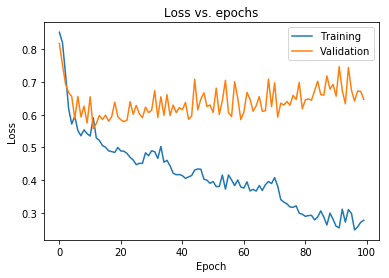

In [18]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [19]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [20]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd), input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [21]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, .3)

In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mae', accuracy=['mae'])

In [23]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_target, epochs=100, 
                   validation_split=.15, batch_size=64, verbose=False)

In [24]:
# Evaluate the model on the test set
model.evaluate(test_data, test_target, verbose=2)

45/1 - 0s - loss: 0.4821


0.5000884513060252

#### Plot the learning curves

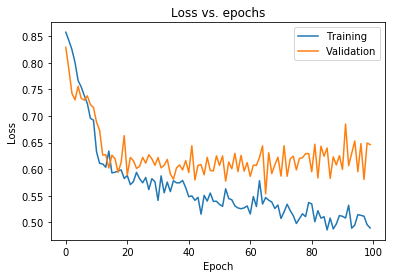

In [25]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [26]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class MyTrainCallBack(Callback):
    
    def on_train_begin(self, logs=None):
        print(f'Starting training....')
        
    def on_train_end(self, logs=None):
        print(f'Training end....')
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f'Begin Epcho :{epoch}')
        
    def on_epoch_end(self, epoch, logs=None):
        print(f'End Epcho :{epoch}')
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f'Start of Batch :{batch}')
        
    def on_train_batch_end(self, batch, logs=None):
        print(f'End of Batch :{batch}')
        
        

In [27]:
# Re-build the model

model = get_regularised_model(1e-5, .3)

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

#### Train the model with the callback

In [29]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_target, epochs=3, batch_size=128, verbose=False, callbacks=[MyTrainCallBack()])

Starting training....
Begin Epcho :0
Start of Batch :0
End of Batch :0
Start of Batch :1
End of Batch :1
Start of Batch :2
End of Batch :2
Start of Batch :3
End of Batch :3
End Epcho :0
Begin Epcho :1
Start of Batch :0
End of Batch :0
Start of Batch :1
End of Batch :1
Start of Batch :2
End of Batch :2
Start of Batch :3
End of Batch :3
End Epcho :1
Begin Epcho :2
Start of Batch :0
End of Batch :0
Start of Batch :1
End of Batch :1
Start of Batch :2
End of Batch :2
Start of Batch :3
End of Batch :3
End Epcho :2
Training end....


In [30]:
# Evaluate the model
class MyTestCallBack(Callback):
    
    def on_test_begin(self, logs=None):
        print(f'Starting test....')
        
    def on_test_end(self, logs=None):
        print(f'Test end....')
                
    def on_test_batch_begin(self, batch, logs=None):
        print(f'Start of Batch :{batch}')
        
    def on_test_batch_end(self, batch, logs=None):
        print(f'End of Batch :{batch}')
        
model.evaluate(test_data, test_target, verbose=False, callbacks=[MyTestCallBack()])

Starting test....
Start of Batch :0
End of Batch :0
Start of Batch :1
End of Batch :1
Test end....


[0.877436547809177, 0.0]

In [31]:
# Make predictions with the model
class MyPredCallBack(Callback):
    
    def on_predict_begin(self, logs=None):
        print(f'Starting predict....')
        
    def on_predict_end(self, logs=None):
        print(f'predict end....')
                
    def on_predict_batch_begin(self, batch, logs=None):
        print(f'Start of Batch :{batch}')
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f'End of Batch :{batch}')

predictions = model.predict(test_data, verbose=False, callbacks=[MyPredCallBack()])        

Starting predict....
Start of Batch :0
End of Batch :0
Start of Batch :1
End of Batch :1
predict end....


***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [59]:
# Re-train the unregularised model
unRegularisedModel = getModel()
unRegularisedModel.compile(optimizer='adam', loss='mae')
unreg_history = unRegularisedModel.fit(train_data, train_target, validation_split=.15,
         epochs=100, batch_size=64, verbose=False,
         callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

In [60]:
# Evaluate the model on the test set
unRegularisedModel.evaluate(test_data, test_target, verbose=2)

45/1 - 0s - loss: 0.5236


0.48925969468222724

In [61]:
# Re-train the regularised model
regularisedModel = get_regularised_model(1e-8, .2)
regularisedModel.compile(optimizer='adam', loss='mae')
reg_history = regularisedModel.fit(train_data, train_target, validation_split=.15,
         epochs=100, batch_size=64, verbose=False,
         callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


In [62]:
# Evaluate the model on the test set
regularisedModel.evaluate(test_data, test_target, verbose=2)


45/1 - 0s - loss: 0.5158


0.47067162990570066

#### Plot the learning curves

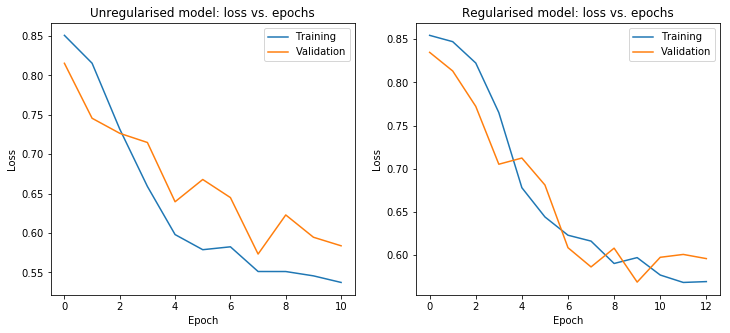

In [63]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()